In [31]:
import snap
import numpy as np
import pandas as pd
from itertools import permutations
from matplotlib import pyplot as plt
import random
import glob


## This looks at one batch of data and describes the networks per batch

#CAM_YEAR = 2000
## we need to translate from congress term to year
#term = 107 ## corresponding to 2001-2002 years

CAM_YEAR = 1994
term = 104 #'95-'96

In [32]:
## load contribution to candidates
filePath = "../data/financials/contributions_to_candidates/"
allFiles = filePath + str(CAM_YEAR) + ".txt"

print allFiles

result = pd.read_table(allFiles, sep='|', index_col=False, low_memory=False, 
                 names=[
                 'CMTE_ID'
                 ,'AMNDT_IND'
                 ,'RPT_TP'
                 ,'TRANSACTION_PGI'
                 ,'IMAGE_NUM'
                 ,'TRANSACTION_TP'
                 ,'ENTITY_TP'
                 ,'NAME'
                 ,'CITY'
                 ,'STATE'
                 ,'ZIP_CODE'
                 ,'EMPLOYER'
                 ,'OCCUPATION'
                 ,'TRANSACTION_DT'
                 ,'TRANSACTION_AMT'
                 ,'OTHER_ID'
                 ,'CAND_ID'
                 ,'TRAN_ID'
                 ,'FILE_NUM'
                 ,'MEMO_CD'
                 ,'MEMO_TEXT'
                 ,'SUB_ID'
                 ])


../data/financials/contributions_to_candidates/1994.txt


In [33]:
## process one batch of contribution data

result = result[['CMTE_ID','TRANSACTION_DT', 'TRANSACTION_AMT', 'CAND_ID']]
#result = result[['CMTE_ID','CAND_ID']]
result = result.groupby(['CMTE_ID','TRANSACTION_DT', 'TRANSACTION_AMT', 'CAND_ID']).size().reset_index(name='Freq')
## remove the case where committees received money from candidates
result = result[result.TRANSACTION_AMT >= 0]

result['ContributionYear'] = (result['TRANSACTION_DT'] % 10000).apply(pd.to_numeric, errors='coerce').fillna(0).astype(np.int64)
##remove the case where years are invalid
result = result[result.ContributionYear > 0]


result["ComNodeId"] = result.groupby(['CMTE_ID']).ngroup() ## NOTE: ComNodeID is generated on the fly; fine because we care about one-node projection onto candidate nodes

print result.head()

     CMTE_ID  TRANSACTION_DT  TRANSACTION_AMT    CAND_ID  Freq  \
0  C00000026       1021994.0             1000  H4AZ05021     1   
1  C00000026       1041993.0              339  H2NJ09016     1   
2  C00000026       1041994.0             1000  S2NJ00080     1   
3  C00000026       1081993.0              150  H6MI12017     1   
4  C00000026       1111993.0             3937  H2NJ09016     1   

   ContributionYear  ComNodeId  
0              1994          0  
1              1993          0  
2              1994          0  
3              1993          0  
4              1993          0  


In [34]:
## load candidate master to map to nodeIDs
filePath = "../processed-data/candidate_node_mapping_manual.csv"

mapping = pd.read_csv(filePath, index_col=False)

print mapping.head(10)

     CAND_ID                   CAND_NAME state      lname   fname  \
0  H4LA05221          ABRAHAM, RALPH LEE    LA    ABRAHAM   RALPH   
1  H4LA05221  ABRAHAM, RALPH LEE DR. JR.    LA    ABRAHAM   RALPH   
2  H4NC12100         ADAMS, ALMA SHEALEY    NC      ADAMS    ALMA   
3  H6AL04098            ADERHOLT, ROBERT    AL   ADERHOLT  ROBERT   
4  H6AL04098          ADERHOLT, ROBERT B    AL   ADERHOLT  ROBERT   
5  H6AL04098         ADERHOLT, ROBERT B.    AL   ADERHOLT  ROBERT   
6  H6AL04098    ADERHOLT, ROBERT B. REP.    AL   ADERHOLT  ROBERT   
7  H6AL04098      ADERHOLT, ROBERT BROWN    AL   ADERHOLT  ROBERT   
8  H2CA31125               AGUILAR, PETE    CA    AGUILAR    PETE   
9  S2TN00058            ALEXANDER, LAMAR    TN  ALEXANDER   LAMAR   

      minitial bioguide_id  thomas_id  NodeID  
0          LEE     A000374        0.0     0.0  
1  LEE DR. JR.     A000374        0.0     0.0  
2      SHEALEY     A000370     2201.0     1.0  
3          NaN     A000055     1460.0     2.0  


In [35]:
# merge dataframes together
c = pd.merge(result, mapping, on='CAND_ID', how='left')

c = c.fillna('')
c[['NodeID','ComNodeId']] = c[['NodeID','ComNodeId']].apply(pd.to_numeric, errors='coerce').fillna(-1).astype(np.int64)
    
## remove entries where Nid = 0, meaning unsuccessful candidates
c = c[c.fname != '']
c = c[c.NodeID != -1]

In [36]:
print c.head(5)

     CMTE_ID  TRANSACTION_DT  TRANSACTION_AMT    CAND_ID  Freq  \
1  C00000026       1041993.0              339  H2NJ09016     1   
2  C00000026       1041994.0             1000  S2NJ00080     1   
3  C00000026       1081993.0              150  H6MI12017     1   
4  C00000026       1081993.0              150  H6MI12017     1   
5  C00000026       1111993.0             3937  H2NJ09016     1   

   ContributionYear  ComNodeId             CAND_NAME state       lname  \
1              1993          0  TORRICELLI, ROBERT G    NJ  TORRICELLI   
2              1994          0   LAUTENBERG, FRANK R    NJ  LAUTENBERG   
3              1993          0       BONIOR, DAVID E    MI      BONIOR   
4              1993          0  BONIOR, DAVID EDWARD    MI      BONIOR   
5              1993          0  TORRICELLI, ROBERT G    NJ  TORRICELLI   

    fname minitial bioguide_id thomas_id  NodeID  
1  ROBERT        G           0      1163    1815  
2   FRANK        R           0      1381    1298  
3   D

In [37]:
offset = 0

filePathNode = "../processed-data/"
f = filePathNode + "bill_node.csv"

bill = pd.read_csv(f, delimiter= ",", index_col=False)

offset = bill['NId'].apply(pd.to_numeric, errors='coerce').fillna(0).astype(np.int64).max()

print "Committee NodeID Offset is %d" % (offset + 1)

Committee NodeID Offset is 231726


In [38]:
c['ComNodeId'] = c['ComNodeId'] + offset + 1
print(c.head(5))

     CMTE_ID  TRANSACTION_DT  TRANSACTION_AMT    CAND_ID  Freq  \
1  C00000026       1041993.0              339  H2NJ09016     1   
2  C00000026       1041994.0             1000  S2NJ00080     1   
3  C00000026       1081993.0              150  H6MI12017     1   
4  C00000026       1081993.0              150  H6MI12017     1   
5  C00000026       1111993.0             3937  H2NJ09016     1   

   ContributionYear  ComNodeId             CAND_NAME state       lname  \
1              1993     231726  TORRICELLI, ROBERT G    NJ  TORRICELLI   
2              1994     231726   LAUTENBERG, FRANK R    NJ  LAUTENBERG   
3              1993     231726       BONIOR, DAVID E    MI      BONIOR   
4              1993     231726  BONIOR, DAVID EDWARD    MI      BONIOR   
5              1993     231726  TORRICELLI, ROBERT G    NJ  TORRICELLI   

    fname minitial bioguide_id thomas_id  NodeID  
1  ROBERT        G           0      1163    1815  
2   FRANK        R           0      1381    1298  
3   D

We have now a contribution data for the year we picked, in CAM_YEAR

In [39]:
print c.shape

(402110, 15)


In [40]:
## create an undirect graph
G = snap.TUNGraph.New()
for index, row in c.iterrows():
    if G.IsNode(row['NodeID']) is False:
        G.AddNode(row['NodeID'])
    if G.IsNode(row['ComNodeId']) is False:
        G.AddNode(row['ComNodeId'])
    if G.IsEdge(row['NodeID'], row['ComNodeId']) is False:
        G.AddEdge(row['NodeID'], row['ComNodeId'])

print "G node count is %d" % (G.GetNodes())
print "G edge count is %d" % (G.GetEdges())

G node count is 4327
G edge count is 105484


## Describe the Networks

joining to the bill data in the immediately following year. E.g., if we are looking to 2000's campaign, contribution record, we need to look at 2002's congress membership and bill co-authorship data, to respect causality

In [41]:
filePathNode = "../processed-data/"
f = filePathNode + "legislator_bill_edge_list.csv"

bills = pd.read_csv(f, delimiter= ",", index_col=False)
print bills.head()

   SrcNId  DstNId  congress_term date_signed
0   10000    1002            100  1987-01-06
1   10001     649            101  1989-01-03
2   10001      40            101  1989-01-03
3   10001     710            101  1989-04-04
4   10001     888            101  1989-01-03


In [42]:


bills = bills[bills['congress_term'] == term]
print(bills.head())

     SrcNId  DstNId  congress_term date_signed
165   10004     658            104  1995-01-04
166   10004      48            104  1995-01-04
167   10004     752            104  1995-01-04
168   10004     892            104  1995-01-04
169   10004     894            104  1995-01-04


In [43]:
## Join bill data to campaign contribution data (essentially only include legislators found in the bill data)
overall = pd.merge(c, bills, left_on='NodeID', right_on = 'DstNId', how='inner')

print(c.shape)
print(bills.shape)
print(overall.shape)

(402110, 15)
(95678, 4)
(62576326, 19)


In [44]:
print overall.head(5)

     CMTE_ID  TRANSACTION_DT  TRANSACTION_AMT    CAND_ID  Freq  \
0  C00000026       1041993.0              339  H2NJ09016     1   
1  C00000026       1041993.0              339  H2NJ09016     1   
2  C00000026       1041993.0              339  H2NJ09016     1   
3  C00000026       1041993.0              339  H2NJ09016     1   
4  C00000026       1041993.0              339  H2NJ09016     1   

   ContributionYear  ComNodeId             CAND_NAME state       lname  \
0              1993     231726  TORRICELLI, ROBERT G    NJ  TORRICELLI   
1              1993     231726  TORRICELLI, ROBERT G    NJ  TORRICELLI   
2              1993     231726  TORRICELLI, ROBERT G    NJ  TORRICELLI   
3              1993     231726  TORRICELLI, ROBERT G    NJ  TORRICELLI   
4              1993     231726  TORRICELLI, ROBERT G    NJ  TORRICELLI   

    fname minitial bioguide_id thomas_id  NodeID  SrcNId  DstNId  \
0  ROBERT        G           0      1163    1815   10080    1815   
1  ROBERT        G    

### Plot Degree Distribution

In [45]:
bill_cand = []
for index, row in bills.iterrows():
    bill_cand.append(row['DstNId'])
bill_cand = list(set(bill_cand)) ##dedup

G_cand = snap.TUNGraph.New()
for index, row in c.iterrows():
    if G_cand.IsNode(row['NodeID']) is False and row['NodeID'] in bill_cand:
        G_cand.AddNode(row['NodeID'])
    if G_cand.IsNode(row['ComNodeId']) is False and row['NodeID'] in bill_cand:
        G_cand.AddNode(row['ComNodeId'])
    if G_cand.IsEdge(row['NodeID'], row['ComNodeId']) is False and row['NodeID'] in bill_cand:
        G_cand.AddEdge(row['NodeID'], row['ComNodeId'])

print "G_cand node count is %d" % (G_cand.GetNodes())
print "G_cand edge count is %d" % (G_cand.GetEdges())

G_cand node count is 3903
G_cand edge count is 87612


In [46]:
# Find clique size

cand = []
com = []
#b = []
for NI in G_cand.Nodes():
    if NI.GetId() < 10000:
        cand.append(NI.GetOutDeg())
    else:
        com.append(NI.GetOutDeg())
        
print "Campaign network max degree count is %d for candidates, out of %d pool" % (max(cand), len(cand))
print "Campaign network max degree count is %d for committees, out of %d pool" % (max(com), len(com))
#print "Campaign network max clique size is %d for bills, out of %d pool" % (max(b), len(b)) ## this is with joining to the bill data

Campaign network max degree count is 765 for candidates, out of 529 pool
Campaign network max degree count is 435 for committees, out of 3374 pool


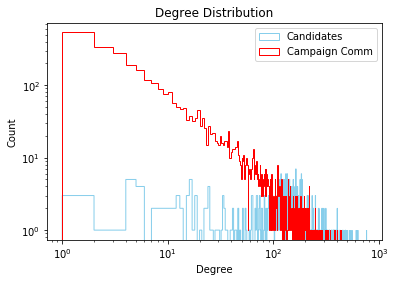

In [47]:
plt.hist(cand, bins=range(min(cand), max(cand)+1), color = "skyblue", ec="skyblue", histtype = 'step', label="Candidates")
plt.hist(com, bins=range(min(com), max(com)+1), color="red", ec="red", histtype = 'step', label= 'Campaign Comm')
plt.xscale("log")
plt.yscale("log")
plt.xlabel('Degree')
plt.ylabel('Count')
plt.title('Degree Distribution')
plt.legend()
plt.show()
## red shows power law, similar to paper collaboration network in HW1. Makes sense, as even within one year, people collaborate a lot tgt
## blue is closer to small world. 

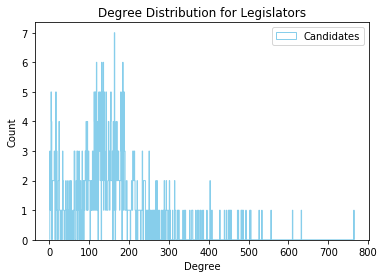

In [48]:
plt.figure()
plt.hist(cand, bins=range(min(cand), max(cand)+1), color = "skyblue", ec="skyblue", histtype = 'step', label="Candidates")
plt.xlabel('Degree')
plt.ylabel('Count')
plt.title('Degree Distribution for Legislators')
plt.legend()
plt.show()

In [49]:
## Fold G_cand to create a one-node projection onto candidate nodes

H = snap.TUNGraph.New()

for i in G_cand.Nodes():
    for j in G_cand.Nodes():
        if (i.GetId() < j.GetId() and j.GetId() < 10000): #10000 is the upper limit for candidate nodes
            NbrV = snap.TIntV()
            Num = snap.GetLen2Paths(G_cand, i.GetId(), j.GetId(), NbrV)
            if Num > 0:
                if H.IsNode(i.GetId()) == False:
                    H.AddNode(i.GetId())
                if H.IsNode(j.GetId()) == False:
                    H.AddNode(j.GetId())
                if H.IsEdge(i.GetId(), j.GetId()) == False:
                    H.AddEdge(i.GetId(),j.GetId())

print "Compressed Graph Node count total: %d" % (H.GetNodes())

print "Compressed Edge count total: %d" % (H.GetEdges())

GraphClustCoeff = snap.GetClustCf(H, -1)
print "Campaign Network Clustering coefficient: %f" % GraphClustCoeff

Compressed Graph Node count total: 528
Compressed Edge count total: 136013
Campaign Network Clustering coefficient: 0.982753


In [50]:
MxWcc = snap.GetMxWcc(H)
print MxWcc.GetNodes()
print MxWcc.GetEdges()

528
136013


In [51]:
MxScc = snap.GetMxScc(H)
print "Campaign Network Max Strongly Connected Component Node Count: %d" % MxScc.GetNodes()
print "Campaign Network Max Strongly Connected Component Edge Count: %d" % MxScc.GetEdges()


Campaign Network Max Strongly Connected Component Node Count: 528
Campaign Network Max Strongly Connected Component Edge Count: 136013


## Looking at bills data

In [52]:
print bills.head()

     SrcNId  DstNId  congress_term date_signed
165   10004     658            104  1995-01-04
166   10004      48            104  1995-01-04
167   10004     752            104  1995-01-04
168   10004     892            104  1995-01-04
169   10004     894            104  1995-01-04


In [53]:
print "...Looking at Bill - Legislator Graph "
## NOW, create one-node projection onto legislator graphs

G_bill = snap.TUNGraph.New()
for index, row in bills.iterrows():
    if G_bill.IsNode(row['SrcNId']) is False:
        G_bill.AddNode(row['SrcNId'])
    if G_bill.IsNode(row['DstNId']) is False:
        G_bill.AddNode(row['DstNId'])
    if G_bill.IsEdge(row['SrcNId'], row['DstNId']) is False:
        G_bill.AddEdge(row['SrcNId'], row['DstNId'])

print "G_bill node count is %d" % (G_bill.GetNodes())
print "G_bill edge count is %d" % (G_bill.GetEdges())

## Find clique size
cand = []
com = []
#b = []
for NI in G_bill.Nodes():
    if NI.GetId() < 10000:
        cand.append(NI.GetOutDeg())
    else:
        com.append(NI.GetOutDeg())
        
print "Bill network max node degree is %d for legislators, out of %d pool" % (max(cand), len(cand))
print "Bill network max node degree is %d for bills, out of %d pool" % (max(com), len(com))

## Fold G_cand to create a one-node projection onto candidate nodes

H_bill = snap.TUNGraph.New()

for i in G_bill.Nodes():
    for j in G_bill.Nodes():
        if (i.GetId() < j.GetId() and j.GetId() < 10000): #10000 is the upper limit for candidate nodes
            NbrV = snap.TIntV()
            Num = snap.GetCmnNbrs(G_bill,i.GetId(),j.GetId())
            #Num = snap.GetLen2Paths(G_bill, i.GetId(), j.GetId(), NbrV)
            if Num != 0:
                if H_bill.IsNode(i.GetId()) == False:
                    H_bill.AddNode(i.GetId())
                if H_bill.IsNode(j.GetId()) == False:
                    H_bill.AddNode(j.GetId())
                if H_bill.IsEdge(i.GetId(), j.GetId()) == False:
                    H_bill.AddEdge(i.GetId(),j.GetId())

print "One-node Projected Graph Node count total: %d" % (H_bill.GetNodes())

print "One-node Projected Edge count total: %d" % (H_bill.GetEdges())

GraphClustCoeff = snap.GetClustCf(H_bill, -1)
print "Bill Network Clustering coefficient: %f" % GraphClustCoeff

MxWcc = snap.GetMxWcc(H_bill)
print "Bill Network Max Weakly Connected Component Node Count: %d" % MxWcc.GetNodes()
print "Bill Network Max Weakly Connected Component Edge Count: %d" % MxWcc.GetEdges()

MxScc = snap.GetMxScc(H_bill)
print "Bill Network Max Strongly Connected Component Node Count: %d" % MxScc.GetNodes()
print "Bill Network Max Strongly Connected Component Edge Count: %d" % MxScc.GetEdges()


...Looking at Bill - Legislator Graph 
G_bill node count is 8537
G_bill edge count is 95678
Bill network max node degree is 508 for legislators, out of 546 pool
Bill network max node degree is 346 for bills, out of 7991 pool
One-node Projected Graph Node count total: 546
One-node Projected Edge count total: 103722
Bill Network Clustering coefficient: 0.998163
Bill Network Max Weakly Connected Component Node Count: 546
Bill Network Max Weakly Connected Component Edge Count: 103722
Bill Network Max Strongly Connected Component Node Count: 546
Bill Network Max Strongly Connected Component Edge Count: 103722


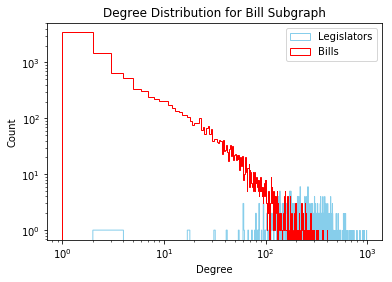

In [30]:
plt.hist(cand, bins=range(min(cand), max(cand)+1), color = "skyblue", ec="skyblue", histtype = 'step', label="Legislators")
plt.hist(com, bins=range(min(com), max(com)+1), color="red", ec="red", histtype = 'step', label= 'Bills')
plt.xscale("log")
plt.yscale("log")
plt.xlabel('Degree')
plt.ylabel('Count')
plt.title('Degree Distribution for Bill Subgraph')
plt.legend()
plt.show()

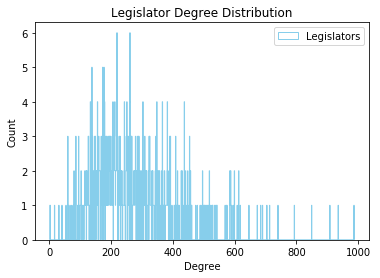

In [27]:
plt.hist(cand, bins=range(min(cand), max(cand)+1), color = "skyblue", ec="skyblue", histtype = 'step', label="Legislators")
plt.xlabel('Degree')
plt.ylabel('Count')
plt.title('Legislator Degree Distribution')
plt.legend()
plt.show()